# NLP exploration with Reddit data

I came across this old article about [Creating a Data Table using Data from Reddit](https://medium.com/swlh/dashboards-in-python-using-dash-creating-a-data-table-using-data-from-reddit-1d6c0cecb4bd) and I enjoyed the idea of [Reddit](https://www.reddit.com/) data exploration. So I thought, why not try it out with atoti?

That is indeed what I did. It's a pretty short notebook used to explore the data downloaded with [atoti](https://www.atoti.io/).
Hence I did some additional work:
- [Natural Language Processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing) with [spaCy](https://spacy.io/) to extract [named entities](https://spacy.io/api/annotation#named-entities)
- Real-time dashboarding with atoti

To achieve real-time, I used threads to trigger the below process flow on regular intervals:

<img src="https://data.atoti.io/notebooks/reddit/thread_task.png" alt="atoti table" width="800"/>

### Pre-requisite:
You should have the Reddit [API key](https://medium.com/swlh/dashboards-in-python-using-dash-creating-a-data-table-using-data-from-reddit-1d6c0cecb4bd#08db) in order to perform scraping with PRAW.  
Also, uncomment and run the next 2 commands if you haven't install spaCy before.

In [1]:
# if this doesn't work, try running pip install praw in terminal
# !pip install praw spacy

In [2]:
# This only has to be downloaded once. Uncomment if you haven't
# !python -m spacy download en_core_web_sm

In [3]:
import sched
import time
from collections import Counter
from datetime import datetime

import atoti as tt
import pandas as pd
import praw
import spacy
from atoti.config import create_config

from utils import config

## NLP with spaCy and atoti  

I'm going to use spaCy to perform some NLP to extract different named entities from the posting.  
To do so, I have found a nice [reference](https://realpython.com/natural-language-processing-spacy-python/) article. Let's start by loading the [starter model](https://spacy.io/models) from spaCy.

In [4]:
nlp = spacy.load("en_core_web_sm")

#### NLP - Extracting named entities with spaCy

Before going into the implementation of the NLP, I'm creating a `entities.csv` to which I will write the entities’ attributes once I extracted them from the post.  
This is in preparation for real-time data loading into atoti datacube where I could leverage on the `watch` feature of `session.read_csv` to trigger the loading on update of the file.  

In [5]:
entity_file_name = "entities.csv"
entity_file = open(entity_file_name, "w", encoding="utf-8")
entity_file.write("id|category|text|text count\n")
entity_file.flush()

With spaCy, I am going to extract the following [named entities](https://spacy.io/api/annotation#named-entities) from each Reddit posting:  
- Organizations
- Person
- Geographical Locations
- Events
- Product
- NORP (Nationalities/religious/political groups)

In the `get_post_entity` function below, I create a processed [Doc](https://spacy.io/api/doc) object that gives a sequence of [tokens](https://spacy.io/api/token) for each post. Using the tokens, I can identify the entity with its label.  

By using `Counter(list).items()`, I will be able to get a list containing all the terms related to the mentioned entity type and the number of time it appeared. 
Note that you could also get _n_ number of _most common_ items from the list using [Counter](https://docs.python.org/2/library/collections.html). However, I chose to get all items as I could easily use atoti's filter to achieve the same result. 

The list of entities with its post's id is output to the `entities.csv` created above.  

In [6]:
# convert list of tuples to list of entity with its attributes
def get_entity_list(id, category, item_list):
    # perform data clean up such as trim and removing line break and double-quotes
    return list(
        map(
            lambda a: "|".join(
                '"{}"'.format(str(e).strip().replace("\n", " ").replace('"', '""'))
                for e in ((id, category,) + a)
            ),
            list(item_list),
        )
    )


# for each posting/title, we extract the entities
def get_post_entity(id, text):

    post_entity = []
    org_list = []
    person_list = []
    gpe_list = []
    event_list = []
    product_list = []
    norp_list = []

    nlp_text = nlp(text)
    # ent is a Span object with various attributes
    for ent in nlp_text.ents:
        if ent.label_ == "ORG":
            org_list.append(ent.text)
        elif ent.label_ == "PERSON":
            person_list.append(ent.text)
        elif ent.label_ == "GPE":
            gpe_list.append(ent.text)
        elif ent.label_ == "EVENT":
            event_list.append(ent.text)
        elif ent.label_ == "PRODUCT":
            product_list.append(ent.text)
        elif ent.label_ == "NORP":
            product_list.append(ent.text)

    org = Counter(org_list).items()
    post_entity = get_entity_list(id, "Organization", org)

    person = Counter(person_list).items()
    post_entity = post_entity + get_entity_list(id, "Person", person)

    gpe = Counter(gpe_list).items()
    post_entity = post_entity + get_entity_list(id, "Geographical Location", gpe)

    event = Counter(event_list).items()
    post_entity = post_entity + get_entity_list(id, "Event", event)

    products = Counter(product_list).items()
    post_entity = post_entity + get_entity_list(id, "Product", products)
    
    norp = Counter(norp_list).items()
    post_entity = post_entity + get_entity_list(id, "NORP", norp)

    if len(post_entity) > 0:
        entity_file.writelines("%s\n" % x for x in post_entity)

    return post_entity

#### NLP - Preprocessing with spaCy

Through preprocessing, I normalized the text:
- lowercase
- remove [stop words](https://en.wikipedia.org/wiki/Stop_words) (words that doesn't add much meaning to the sentence) and punctuation symbols
- [lemmatizes](https://en.wikipedia.org/wiki/Lemmatisation) each token.

This way, the named entities extracted can easily be grouped to compute the number of times it is mentioned.

In [7]:
# https://realpython.com/natural-language-processing-spacy-python/
def is_token_allowed(token):
    if not token or not token.string.strip() or token.is_stop or token.is_punct:
        return False
    return True


def preprocess_token(token):
    # Reduce token to its lowercase lemma form
    return token.lemma_.strip().lower()


def normalize(category, id, post):
    nlp_text = nlp(post)

    complete_filtered_tokens = [
        preprocess_token(token) for token in nlp_text if is_token_allowed(token)
    ]

    lemmatized_sentence = " ".join(complete_filtered_tokens)

    if category == "title":
        get_post_entity(id, lemmatized_sentence)

    return lemmatized_sentence

Normalizing the post invokes `get_post_entity`, triggering the extraction of named entities into csv.

## Using PRAW to connect to Reddit

[PRAW](https://praw.readthedocs.io/en/latest/) is the Python Reddit API Wrapper that we used to download the submissions from the _subreddits_.
I'm not going into the details of the data scraping.  
**You can check out the original article on how you can get the [API key](https://medium.com/swlh/dashboards-in-python-using-dash-creating-a-data-table-using-data-from-reddit-1d6c0cecb4bd#08db)**.  
I've excluded the config file from the source :)

In [8]:
# create a reddit connection
reddit = praw.Reddit(
    client_id=config.cid, client_secret=config.csec, user_agent=config.ua
)

In order to do more analysis, I created a function to get the latest postings. This function will allow me to configure the number of postings to download, and from which subreddit to download the postings from.

Unlike the original article, I decided to format `created` into _datetime_ and splitted it into `created_date` and `created_time` as I figured this would allow me to have consolidated view on date level or drill down to the time level.

Referencing the [PRAW documentation](https://praw.readthedocs.io/en/latest/code_overview/models/submission.html#submission) for the submission attributes, I added _id_ and _author_ to the list as well. Important to note is that for real-time, I will be polling the latest 100 postings at a 30 seconds intervals. Potentially there will be duplicated postings across the pollings. Storing the _id_ allows me to **leverage on atoti's capability to update existing posts instead of inserting duplicated postings**.

In [9]:
def get_latest_posts(subreddit, count):
    # list for df conversion
    _posts = []
    # return 100 new posts from wallstreetbets
    new_bets = reddit.subreddit(subreddit).new(limit=count)
    # return the important attributes
    for post in new_bets:
        # normalize the post and perform NLP named entities extraction
        lemmatized_post = normalize("post", post.id, post.selftext)
        lemmatized_title = normalize("title", post.id, post.title)
        _posts.append(
            [
                post.id,
                post.author,
                post.title,
                post.score,
                post.num_comments,
                post.selftext,
                lemmatized_post,
                lemmatized_title,
                post.created,
                post.pinned,
                post.total_awards_received,
            ]
        )

    # create a dataframe
    _posts = pd.DataFrame(
        _posts,
        columns=[
            "id",
            "author",
            "title",
            "score",
            "comments",
            "post",
            "lemmatized post",
            "lemmatized title",
            "created",
            "pinned",
            "total awards",
        ],
    )

    _posts["created"] = pd.to_datetime(_posts["created"], unit="s")
    _posts["created date"] = pd.to_datetime(_posts["created"], unit="s").dt.date
    _posts["created time"] = pd.to_datetime(_posts["created"], unit="s").dt.time
    _posts["subreddit"] = subreddit

    return _posts

To kickstart, I test downloaded the newest 500 post from the subreddit _wallstreetbets_.  
This data will be loaded into atoti's **in-memory datacube** later on. This means that the **amount of data that can be loaded is limited only by the hosting machine's capacity**. You could adjust the number of postings you want to look at according to your machine's memory capacity.

In [10]:
posts = get_latest_posts("wallstreetbets", 500)
entity_file.flush()

# check the number of posts retrieved
len(posts)

500

I adapted the below code from the original article and used the Reddit's title instead of post for NLP. Mainly because the Subreddits that I chose has more text in the title than the post.  
The function uses Pandas dataframe to compute some simple statistics about the text in the posts.

In [11]:
def get_nlp_features(_posts):
    # copy the dataframe
    df = _posts.copy()
    # count words in post
    df["words"] = df["title"].apply(lambda x: len(x.split()))
    # count characters in post
    df["chars"] = df["title"].apply(lambda x: len(x.replace(" ", "")))
    # calculate word density
    df["word density"] = (df["words"] / (df["chars"] + 1)).round(3)
    # count unique words
    df["unique words"] = df["title"].apply(lambda x: len(set(w for w in x.split())))
    # percent of unique words
    df["unique density"] = (df["unique words"] / df["words"]).round(3)

    return df

By running the function above on the posts that I have downloaded, we will get a dataset with similar structure to the original article.

In [12]:
df = get_nlp_features(posts)
df.head(3)

,id,author,title,score,comments,post,lemmatized post,lemmatized title,created,pinned,total awards,created date,created time,subreddit,words,chars,word density,unique words,unique density
0,l5uesr,duckduckew,Israeli Cannabis Company to Go Public via SPAC,1,0,SBVRF to merge with Israeli cannabis company C...,sbvrf merge israeli cannabis company canndoc c...,israeli cannabis company public spac,2021-01-27 10:42:39,False,0,2021-01-27,10:42:39,wallstreetbets,8,39,0.200,8,1.0
1,l5uesn,Blubcum,What happened if Melvin files bankruptcy? Will...,1,0,,,happen melvin file bankruptcy short cover,2021-01-27 10:42:39,False,0,2021-01-27,10:42:39,wallstreetbets,12,64,0.185,12,1.0
2,l5ueqw,17Jos1,Best stock app,1,0,Hey everyone! Apologies if I did something wro...,hey apology wrong post new stock wsb y’alls fa...,good stock app,2021-01-27 10:42:35,False,0,2021-01-27,10:42:35,wallstreetbets,3,12,0.231,3,1.0


## atoti cube creation for NLP analysis

Finally we can get started with atoti. Let's create a session with the [sampling_mode](https://docs.atoti.io/0.4.2/lib/atoti.html#module-atoti.sampling) to set full, so that I can see all the data once it is loaded.

In [13]:
config = create_config(metadata_db="./metadata.db", sampling_mode=tt.sampling.FULL)
session = tt.create_session(config=config)

#### atoti datastores

I will create a `Reddit Posts` store for the data as per the original article. 

In [14]:
reddit_store = session.read_pandas(df, keys=["id"], store_name="Reddit_Posts")
reddit_store.head(3)

,author,title,score,comments,post,lemmatized post,lemmatized title,created,pinned,total awards,created date,created time,subreddit,words,chars,word density,unique words,unique density
id,,,,,,,,,,,,,,,,,,
l5uesr,duckduckew,Israeli Cannabis Company to Go Public via SPAC,1,0,SBVRF to merge with Israeli cannabis company C...,sbvrf merge israeli cannabis company canndoc c...,israeli cannabis company public spac,2021-01-27 10:42:39,False,0,2021-01-27,10:42:39,wallstreetbets,8,39,0.200,8,1.0
l5uesn,Blubcum,What happened if Melvin files bankruptcy? Will...,1,0,N/A,N/A,happen melvin file bankruptcy short cover,2021-01-27 10:42:39,False,0,2021-01-27,10:42:39,wallstreetbets,12,64,0.185,12,1.0
l5ueqw,17Jos1,Best stock app,1,0,Hey everyone! Apologies if I did something wro...,hey apology wrong post new stock wsb y’alls fa...,good stock app,2021-01-27 10:42:35,False,0,2021-01-27,10:42:35,wallstreetbets,3,12,0.231,3,1.0


For my experiment with spaCy, I create a `Entities` store to store the named entities.  
Below, I set `watch=True` for the entities.csv such that any update to the file will trigger an upload to the datastore.

In [15]:
entity_store = session.read_csv(
    entity_file_name,
    keys=["id", "category", "text"],
    store_name="Entities",
    watch=True,
    sep="|",
)

In [16]:
entity_store.head()

text count
id     category     text                                    
l5uesr Organization cannabis company public spac           1
       Product      israeli                                1
l5uem6 Person       wsb                                    1
l5uek9 Organization mod                                    1
l5udbi Person       melvin cap milkshakes                  1

I join the `Entities` store to `Reddit Posts` which I decided to use as the base store.  
Note that atoti automatically joins columns with the same name across both stores. You could define your own [mapping](https://docs.atoti.io/0.4.2/lib/atoti.html?highlight=join#atoti.store.Store.join) otherwise.

In [17]:
reddit_store.join(entity_store)

#### atoti cube creation - No measures

By default, atoti will automatically create hierarchies and measures from the datastore based on the data type of the columns.  
In this case, I prefer to manually create my measures, hence I set the [mode](https://docs.atoti.io/0.4.2/lib/atoti.html?highlight=create_cube#atoti.session.Session.create_cube) of creation to `no_measures`

In [18]:
cube = session.create_cube(reddit_store, "Reddit", mode="no_measures")

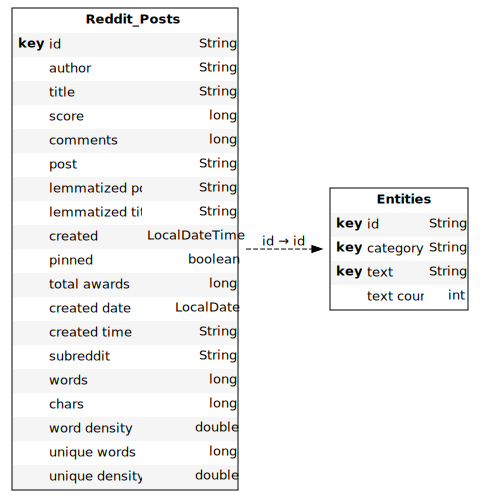

In [19]:
cube.schema

Take a look at the structure of the cube created. Only a `Count` measure is created.

In [20]:
m = cube.measures
l = cube.levels
h = cube.hierarchies
cube

#### Managing hierarchies

Since I am going to create my own measures, I will delete the numeric columns from my hierarchies to avoid confusion with the measures that I will be creating.

In [21]:
del h["text count"]
del h["score"]
del h["comments"]
del h["total awards"]
del h["words"]
del h["chars"]
del h["unique words"]

#### Measures creation

In default `auto` mode, atoti will create a `MEAN` and a `SUM` measure.  
However, as I only require `sum` in my simple use case and in order to demonstrate how simple aggregation can be done with atoti, I created the below measures instead.

In [22]:
m["Text Count"] = tt.agg.sum(entity_store["text count"])
m["Score"] = tt.agg.sum(reddit_store["score"])
m["Comments"] = tt.agg.sum(reddit_store["comments"])
m["Total awards"] = tt.agg.sum(reddit_store["total awards"])
m["Words"] = tt.agg.sum(reddit_store["words"])
m["Chars"] = tt.agg.sum(reddit_store["chars"])
m["Unique words"] = tt.agg.sum(reddit_store["unique words"])
m["Word density"] = tt.agg.sum(reddit_store["word density"])
m["Unique density"] = tt.agg.sum(reddit_store["unique density"])

##### Distinct measure

I use the [`count_distinct`](https://docs.atoti.io/0.4.2/lib/atoti.html?highlight=count_distinct#atoti.agg.count_distinct) function to compute the number of days the data span across.

In [23]:
m["Number days"] = tt.agg.count_distinct(reddit_store["created date"])

##### Cumulative measure

Aggregation with the [`cumulative`](https://docs.atoti.io/0.4.2/lib/atoti.scope.html?highlight=cumulative#atoti.scope.cumulative) scope allows me to see the trend of the posting over the `created` level. By setting the parameter `dense=True`, we can see a continuous plot of the trend even if there are no postings on days in between. 

In [24]:
m["Cumulative Count"] = tt.agg.sum(
    m["contributors.COUNT"], scope=tt.scope.cumulative(l["created"], dense=True)
)

In [25]:
session.visualize("Posting Trends")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

## atoti Pivot table

atoti is currently going through UX and performance upgrade. Hang on with us as more features for the Pivot table will come with future release.

In [26]:
session.visualize("Reddit Data Table")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [27]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

### Real-time dashboarding with atoti

At the moment, I have only loaded data from the subreddit _wallstreetbets_. In the next few cell, I have created functions that allow me to poll the latest 200 postings from some other subreddit groups:
- news
- worldnews
- politics
- technology
- wallstreetbets

Let's switch over to a dashboard that I have prepared in advance by accessing the url from the next cell. After loading the dashboard, trigger the rest of the cells to start the data polling. You can then go back to the dashboard to see it getting refreshed each time new data is downloaded.

In [28]:
session.url + "/#/dashboard/c7c"

'http://localhost:65200/#/dashboard/c7c'

I used [`store.load_pandas`](https://docs.atoti.io/0.4.2/lib/atoti.html?highlight=load_pandas#atoti.store.Store.load_pandas) to load the Pandas dataframe incrementally into the `Reddit Posts` store. For the `Entities` store, the csv file is on `watch` mode, hence any update will trigger data to be uploaded into the datastore. Based on the stores' keys, existing data will be updated and new data will be inserted.

In [29]:
def load_new_subreddit(subreddit):
    posts_news = get_latest_posts(subreddit, 200)
    df_news = get_nlp_features(posts_news)

    reddit_store.load_pandas(df_news)

For demo purpose, I have only set the polling to iterate 10 times with intervals of 30s.

In [30]:
import queue
import threading

should_publish = threading.Event()
update_queue = queue.Queue()


def start_publisher():
    # Do 10 iterations with 30s interval
    starttime = time.time()
    print("Start polling", starttime)
    poll_iteration = 1

    while poll_iteration <= 10:
        print("\rpublishing update ", end="")
        update_queue.put((poll_iteration))
        poll_iteration += 1
        time.sleep(30)
        print("\rawaiting for publishing update", end="")
        should_publish.wait()
        update_queue.join()


def start_update_listener():
    while True:
        poll_iteration = update_queue.get()
        print(poll_iteration, ">>> Start polling from subreddit... ")
        # poll from subreddit
        load_new_subreddit("news")
        print(poll_iteration, "........ Loaded news ")
        
        load_new_subreddit("worldnews")
        print(poll_iteration, "........ Loaded worldnews ")
        
        load_new_subreddit("politics")
        print(poll_iteration, "........ Loaded politics ")
        
        load_new_subreddit("technology")
        print(poll_iteration, "........ Loaded technology ")
        
        load_new_subreddit("wallstreetbets")
        print(poll_iteration, "........ Loaded wallstreetbets ")
        entity_file.flush()
        print(poll_iteration, ">>> End polling from subreddit... ")
        update_queue.task_done()


listener_thread = threading.Thread(target=start_update_listener, daemon=True)
publisher_thread = threading.Thread(target=start_publisher, daemon=True)

In [31]:
publisher_thread.start()
listener_thread.start()
# start publishing
should_publish.set()

Start polling 1611715982.870141
publishing update 1 >>> Start polling from subreddit... 
1 ........ Loaded news 
1 ........ Loaded worldnews 
1 ........ Loaded politics 
1 ........ Loaded technology 
awaiting for publishing update1 ........ Loaded wallstreetbets 
1 >>> End polling from subreddit... 
publishing update 2 >>> Start polling from subreddit... 
2 ........ Loaded news 
2 ........ Loaded worldnews 
2 ........ Loaded politics 
2 ........ Loaded technology 
awaiting for publishing update2 ........ Loaded wallstreetbets 
2 >>> End polling from subreddit... 
publishing update 3 >>> Start polling from subreddit... 
3 ........ Loaded news 
3 ........ Loaded worldnews 


If you would like to stop the data polling before the 10 iterations end, run the below cell.

In [32]:
# pause publishing
should_publish.clear()

In [ ]:
entity_file.close()

#### Dashboard Page - Post Frequency 

This is how the real-time dashboard will look like when the scheduler is running:

<img src="https://data.atoti.io/notebooks/reddit/real-time_dashboarding.gif" alt="atoti table" width="1080"/>

Using the Subreddit's submission id as a unique key, atoti is able to update an existing posting and insert new ones.  
You can see the frequency of posting and trend from each Subreddit.  
From the tree map, you can also see which author's posting generates the most comments.

#### Dashboard Page - NLP Stats

Go to second tab of the dashboard to play with the NLP Statistics using quick filters:

<img src="https://data.atoti.io/notebooks/reddit/NLP_Stats.gif" alt="atoti table" width="1080"/>

If there are too many values to choose, you can also use the "Label contains..." filter option to do a _partial label_ search. Try selecting Trump and Biden to see the number of postings related to them.

#### Dashboard Page - Author Analysis

Go to third tab of the dashboard for interactive analysis of authors:

<img src="https://data.atoti.io/notebooks/reddit/author_analysis.gif" alt="atoti table" width="1080"/>

Perform a drillthrough to see the underlying data behind the selected cell.

Have fun exploring the dashboard! Do play around with some of the ootb widgets such as "Quick Page Filter" that allow you to easily filter the page from the dashboard.